# **Report - Focus Project**

The following is a quick report to keep track of the results for the final submission.

make this nicer-looking

introduction
Structure
Example Usage + Application (vary, to showcase different scenarios)
Tests (same ones, to offer a benchmark for comparison)

## **Linear Congruential Generator**

The Linear Congruential Generator is one of the oldest ways to generate pseudorandom numbers. It's easy to understand and easy to implement, and is hence become on of the best-known approaches to randomness in computers.

The generator is defined by the following relation:

$$X_{n+1} = (aX_n + c) \ \text{mod}\ m$$

with $X$ being the sequence of pseudo-random values, and

1. the *modulus* $m$, $m>0$
2. the *multiplier* $a$, $0<a<m$
3. the *increment* $c$, $0 \leq c < m$
4. the *seed* $X_0$, $0 \leq X_0 < m$

At every step, the formula updates the state and produces a new, pseudo-random number. It is very fast and easy to implement; completely deterministic (same seed → same sequence), but the quality of randomness depends heavily on the choice of 𝑎, 𝑐, and 𝑚.

The main idea is that the modulo operation keeps numbers inside a fixed range, with the recurrence relation generating a sequence that "hops" around within that range. With good parameter choices, these hops can approximate randomness.

The literature talks about some known limitations, but we will see these hands on when we perform some tests on the method. 

Sources:
1. https://en.wikipedia.org/wiki/Linear_congruential_generator

In [1]:
# Example Usage of the LCG Generator 

import sys
import os

# Get the absolute path to the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, project_root)

from prngs.lcg import LCG

# Example Parameters
modulus = 2**32
a = 1664525
c = 1013904223
seed = 42

# Initialize generator
rng = LCG(seed=seed, a=a, c=c, m=modulus)

# Generate 10 random numbers (scaled to [0,1))
for _ in range(10):
    value = LCG.next(rng)
    print(value)

0.2523451747838408
0.08812504541128874
0.5772811982315034
0.22255426598712802
0.37566019711084664
0.02566390484571457
0.4472812858875841
0.1184600037522614
0.8738137057516724
0.9946342753246427


In [2]:
# Example Application of LCG: Estimate pi using Monte Carlo Method
# Good for: Intuitively demonstrating uniformity and independence, but more in the test section.

num_samples = 10000
inside_circle = 0

for _ in range(num_samples):
    x = LCG.next(rng) 
    y = LCG.next(rng)
    if x**2 + y**2 <= 1.0:
        inside_circle += 1

pi_estimate = 4 * inside_circle / num_samples
print(pi_estimate)

3.1192


But just how good is this in more practical terms? Here is where we introduce a set of tests to quantify the goodness of a PRNG.

The first set of tests `general_tests` is a fairly simple one: it takes a look at the distribution of a fairly big number of samples and checks the uniformity and correlation of these in the selected range. All of the analyzed PRNGs should pass these tests. These are the following:
1. **Moments test**: Check if Mean and Variance are off from expected values (expected mean = 0.5, variance = 1/12).
2. **Chi-squared uniformity test**: p < 0.05.
3. **Lag-1 autocorrelatio test**: degree of correlation of the same variables between two successive time intervals.

With these there are also some more visual approaches to test the randomness, e.g. by plotting consecutive numbers and such.

Mean: 0.50124, Variance: 0.08305
Moments test passed
Chi-squared test p-value: 0.87531
Uniformity test passed
Lag-1 autocorrelation: 0.00243
Autocorrelation test passed


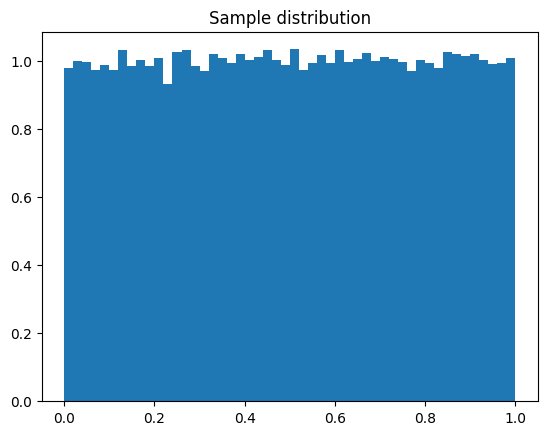

All tests passed!


In [3]:
from tests.tests import general_tests

# Run General Tests
rng = LCG(seed=42, a=a, c=c, m=modulus)

general_tests(lambda: rng.next(), plot=True)

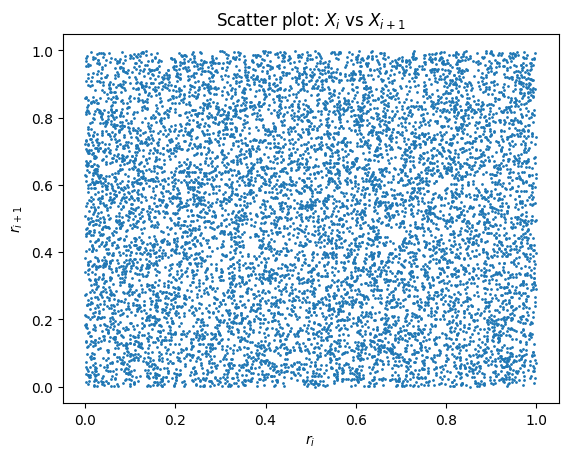

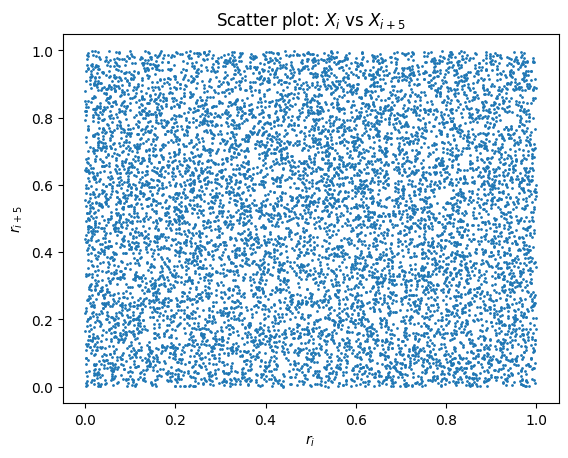

Widget(value='<iframe src="http://localhost:65148/index.html?ui=P_0x1dabb2a8440_0&reconnect=auto" class="pyvis…

In [4]:
# Some Visual Tests also help

import matplotlib.pyplot as plt
import numpy as np
import pyvista as pv

# similar to what we already done in the lecture
samples = np.array([rng.next() for _ in range(10000)])

plt.scatter(samples[:-1], samples[1:], s=1)
plt.title("Scatter plot: $X_i$ vs $X_{i+1}$")
plt.xlabel("$r_i$")
plt.ylabel("$r_{i+1}$")
plt.show()

k = 5 
plt.scatter(samples[:-k], samples[k:], s=1)
plt.title(f"Scatter plot: $X_i$ vs $X_{{i+{k}}}$")
plt.xlabel("$r_i$")
plt.ylabel(f"$r_{{i+{k}}}$")
plt.show()

# Spectral Test (as above, just with r_i, r_{i+1}, r_{i+2})
points = np.array([[samples[i], samples[i+1], samples[i+2]] for i in range(len(samples)-2)])

# cannot figure out pyvista and latex formulas
cloud = pv.PolyData(points)
plotter = pv.Plotter()
plotter.add_points(cloud, render_points_as_spheres=True, point_size=5)
plotter.add_axes()
plotter.add_title("3D embedding: (X_i, X_{i+1}, X_{i+2})")
plotter.show()

The second set of test is more specific and contains some more detailed analysis. These take some inspiration from the *Diehard* set of tests.

### **Period Length**
The period lenght, or full cycle, refers to the point where the random generator comes back to the first state (the seed state) and begins to loop again from the start. This is obviously bad for a PRNG, as at that point every output becomes predicable. There is no general method to determine whether a PRNG algorithm is full-cycle short.

A benefit of LCGs is that an appropriate choice of parameters results in a period which is both known and long. 

In [5]:
from tests.tests import estimate_period

modulus = 2**32
a = 1664525
c = 1013904223
seed = 42

rng = LCG(seed=seed, a=a, c=c, m=modulus)

period = estimate_period(lambda: rng.next(), 100000)

print(f"Estimated period: {period}")

No cycle detected within max iterations
Estimated period: None


### **Birthday Spacing Test**

Choose random points on a large interval with the PRNG to test. The spacings between the points should be asymptotically exponentially distributed, and repetition should be avoided. The name is based on the birthday paradox.

In [6]:
from tests.tests import birthday_spacings_test

modulus = 2**32
a = 1664525
c = 1013904223
seed = 42

lcg = LCG(seed=42)

birthday_spacings_test(lambda: lcg.next(), N=1000, bins=100)

# For perfect continuous uniform random numbers, repeated spacings should be rare.
# LCGs with poor lattice structure may show repeating spacings quite often.
# This test can reveal weaknesses that simple histogram tests completely miss.

Running Birthday Spacings Test...
Total unique spacings: 1
Total collisions: 998
High number of collisions, possible non-randomness.


### **Results**

The LCGs are a powerful category of PRNG, whose goodness heavily rely on the choice of the initial parameters. A bad choice can lead to problems, such as in the case of the RANDU generator (https://en.wikipedia.org/wiki/RANDU). With a good choice of parameters, one gets a fully deterministic PRNGS which satisifies many statistical tests (not all!).

## **Mersenne Twister**
Another really famous and important PRNG is the *Mersenne Twister*. This is the one used by Python's random. It produces 53-bit precision floats and has a period of 2**19937-1. The  implementation in C is both fast and threadsafe, but for education purposes I have written my own version. The Mersenne Twister is one of the most extensively tested random number generators in existence. However, being completely deterministic, it is not suitable for all purposes, and is completely unsuitable for cryptographic purposes.

The **Mersenne Twister (MT19937)** is a widely used pseudo-random number generator with period $2^{19937} - 1$. It maintains an internal state of 624 32-bit integers.

### **1. Initialization**

- The state array `mt[0..623]` is initialized from the seed using:

$$
mt[i] = (f \cdot (mt[i-1] \oplus (mt[i-1] \gg (w-2))) + i) \bmod 2^{32}
$$

where $f = 1812433253$, \(w = 32\).

### **2. Twisting**

When the state is exhausted, new values are generated via:

$$
x = (mt[i] \& \text{upper\_mask}) + (mt[(i+1) \% 624] \& \text{lower\_mask})
$$
$$
mt[i] = mt[(i + 397) \% 624] \oplus (x \gg 1)
$$

If $x$ is odd, an extra XOR with constant $a$ is applied.

### **3. Tempering**

Before output, a series of bit shifts improves randomness:

$$
y = y \oplus ((y \gg u) \& d) \oplus ((y \ll s) \& b) \oplus ((y \ll t) \& c) \oplus (y \gg l)
$$

The tempered value is then scaled to $[0, 1)$.

Sources:
1. https://docs.python.org/3/library/random.html
2. https://en.wikipedia.org/wiki/Mersenne_Twister

In [7]:
from prngs.mersenne_twister import MersenneTwister

# Example Usage of MT

mt = MersenneTwister(seed=42)

# Generate 10 random numbers (scaled to [0,1))
for _ in range(10):
    value = MersenneTwister.next(mt)
    print(value)

0.37454011430963874
0.7965429842006415
0.9507143115624785
0.18343478767201304
0.7319939383305609
0.7796909974422306
0.5986584862694144
0.5968501614406705
0.1560186385177076
0.4458327575121075


In [8]:
# Example Application of LCG: Estimate pi using Monte Carlo Method
# Good for: Intuitively demonstrating uniformity and independence, but more in the test section.

num_samples = 10000
inside_circle = 0

for _ in range(num_samples):
    x = MersenneTwister.next(mt) 
    y = MersenneTwister.next(mt)
    if x**2 + y**2 <= 1.0:
        inside_circle += 1

pi_estimate = 4 * inside_circle / num_samples
print(pi_estimate)

3.1676


Mean: 0.50106, Variance: 0.08320
Moments test passed
Chi-squared test p-value: 0.93455
Uniformity test passed
Lag-1 autocorrelation: -0.00633
Autocorrelation test passed


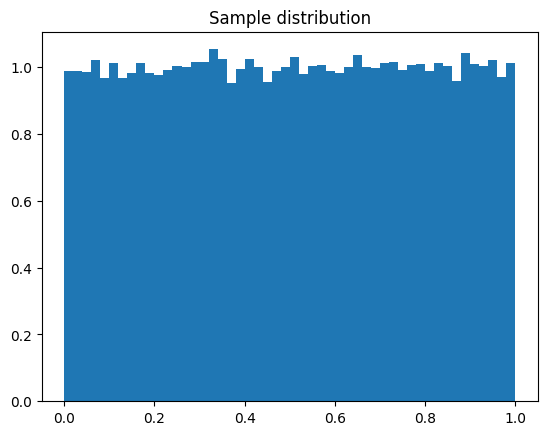

All tests passed!


In [9]:
from tests.tests import general_tests

# Run General Tests
rng = MersenneTwister(seed=42)

general_tests(lambda: mt.next(), plot=True)

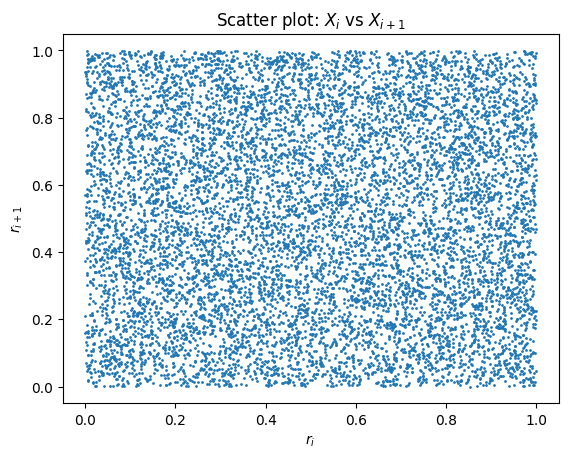

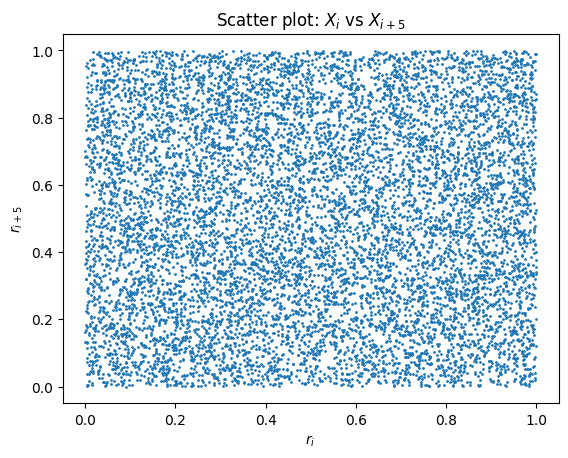

Widget(value='<iframe src="http://localhost:65148/index.html?ui=P_0x1dabc44fc50_1&reconnect=auto" class="pyvis…

In [10]:
# Run Tests

# Some Visual Tests also help

import matplotlib.pyplot as plt
import numpy as np
import pyvista as pv

# similar to what we already done in the lecture
samples = np.array([mt.next() for _ in range(10000)])

plt.scatter(samples[:-1], samples[1:], s=1)
plt.title("Scatter plot: $X_i$ vs $X_{i+1}$")
plt.xlabel("$r_i$")
plt.ylabel("$r_{i+1}$")
plt.show()

k = 5 
plt.scatter(samples[:-k], samples[k:], s=1)
plt.title(f"Scatter plot: $X_i$ vs $X_{{i+{k}}}$")
plt.xlabel("$r_i$")
plt.ylabel(f"$r_{{i+{k}}}$")
plt.show()

# Spectral Test (as above, just with r_i, r_{i+1}, r_{i+2})
points = np.array([[samples[i], samples[i+1], samples[i+2]] for i in range(len(samples)-2)])

# cannot figure out pyvista and latex formulas
cloud = pv.PolyData(points)
plotter = pv.Plotter()
plotter.add_points(cloud, render_points_as_spheres=True, point_size=5)
plotter.add_axes()
plotter.add_title("3D embedding: (X_i, X_{i+1}, X_{i+2})")
plotter.show()

In [11]:
from tests.tests import estimate_period

period = estimate_period(lambda: mt.next(), 10000)

print(f"Estimated period: {period}")

No cycle detected within max iterations
Estimated period: None


In [12]:
from tests.tests import birthday_spacings_test

# not sure about this test!
birthday_spacings_test(lambda: mt.next(), N=25, bins=100)

Running Birthday Spacings Test...
Total unique spacings: 10
Total collisions: 14
High number of collisions, possible non-randomness.


In [13]:
# maybe add some more tests

## **NumPy's approach to randomness**

NumPy provides random number generation via the `numpy.random` module, which is widely used in scientific computing.

### Legacy Generator (`numpy.random`)

- The original NumPy generator (up to NumPy 1.16) was based on the **Mersenne Twister (MT19937)**.
- It used the same algorithm as our custom Mersenne Twister implementation.
- Random numbers were generated with:

```python
import numpy as np
rng = np.random
x = rng.random()
```

While MT19937 has excellent properties (long period, high equidistribution), it is not suitable for all use cases (e.g., cryptography, parallel streams, reproducibility in complex simulations).

### Modern Generator API (`numpy.random.Generator`)
Starting from NumPy 1.17, a new random number API was introduced:
```python
import numpy as np
rng = np.random.default_rng(seed)
x = rng.random()
```

The default generator is now PCG64 (Permuted Congruential Generator 64-bit), which provides:

1. Faster generation

2. Smaller state size (128 bits vs 19937 bits for MT19937)

3. Better statistical properties for modern use cases

4. Easier management of reproducibility in parallel and distributed computing

## **Your laptop's way of doing Random**

While pseudo-random number generators (PRNGs) like LCG, Mersenne Twister, and PCG generate deterministic sequences, your laptop also provides access to **true system-level entropy sources**, which are often used to seed these generators.

### What Is a System-Level Entropy Source?

A **system-level entropy source** is a mechanism provided by the operating system to gather **unpredictable, non-deterministic data** from hardware and system activity. This data serves as the foundation for cryptographic randomness and secure seeding of pseudo-random number generators (PRNGs).

#### Common Entropy Sources

Entropy is collected from low-level, unpredictable events such as:

- Keyboard timings
- Mouse movements
- Disk I/O timings
- Interrupt timings
- Network packet arrival times
- Hardware-based RNGs (e.g. Intel RDRAND)

The operating system collects this data into an **entropy pool**, which is regularly mixed and used to seed secure random number generators.


#### Interfaces to Access Entropy

Operating systems expose randomness via special interfaces:

- **Linux/macOS**:
  - `/dev/random`: a blocking interface that provides random bytes derived from environmental noise (e.g., keyboard, mouse, disk timings). It blocks if not enough entropy is available.
  - `/dev/urandom`: a non-blocking version that uses a PRNG seeded from true entropy. It’s fast and suitable for most applications.

- **Windows**:
  - Uses `CryptGenRandom` or `BCryptGenRandom` under the hood.
  - Also gathers entropy from various hardware and environmental sources.

These system calls are used by:
- Programming languages (e.g., Python’s `secrets` and `os.urandom`)
- Cryptographic libraries
- Seed initialization for PRNGs like NumPy's `default_rng()`

#### Why It Matters

System entropy is:
- **Non-deterministic**: cannot be predicted or reproduced
- **Secure**: suitable for cryptographic use
- **Slow**: so it's usually only used for **initial seeding**

After that, fast PRNGs (like Mersenne Twister, PCG, etc.) take over for generating large volumes of random numbers efficiently.

#### How to Access It in Python

```python
import os
os.urandom(16)  # 16 cryptographically secure random bytes

import secrets
secrets.token_bytes(16)  # Also secure and cross-platform


## **Astro simulations with PRNGs: Star Cluster (Sheet 7)**
We have seen different simulations with different PRNGs, but let's also take a look at one simulation with all of the analyzed generators -> more astro?

Star Cluster

(-10.0, 10.0)

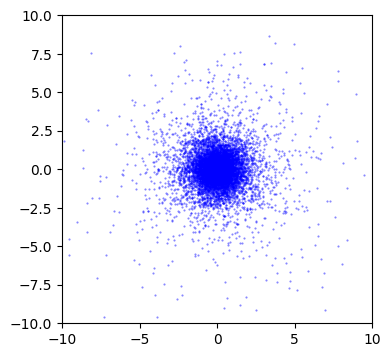

In [23]:
import numpy as np

# GIVEN IMPLEMENTATION
# This code generates a random distribution of stars in 3D space, with a specified mass distribution.

# initialise the random number generator
rng = np.random.Generator(np.random.PCG64(seed=12345))

# Sample isotropic 3d vectors with a given modulus
def rand_vec3d( mod ):
    N = len(mod)
    phi = 2*np.pi*rng.random(size=N)
    theta = np.arccos( 2*rng.random(size=N)-1 )
    v3d = np.zeros( (N,3) )
    v3d[:,0] = mod * np.cos( phi ) * np.sin( theta )
    v3d[:,1] = mod * np.sin( phi ) * np.sin( theta )
    v3d[:,2] = mod * np.cos( theta )
    # subtract mean
    for i in range(3):
        v3d[:,i] -= np.mean(v3d[:,i])
    return v3d

# number of stars
N = 10000

# particle mass is 1/N
m = 1/N

# Sampling the mass, draw radii through inversion sampling from the cumulative mass M
U = rng.random(size=N)
rsamp = U**(1/3)/np.sqrt((1-U**(2/3)))

# create N empty 3D vectors
x3d = rand_vec3d( rsamp )

# make a scatter plot of the stars
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(x3d[:,0], x3d[:,1], marker='.', s=1, c='b', alpha=0.5)
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)

(-10.0, 10.0)

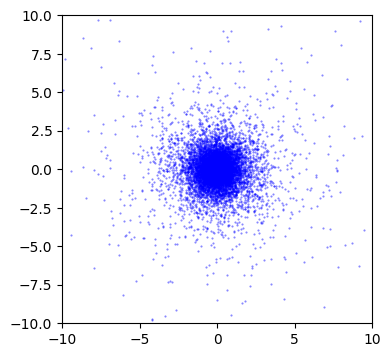

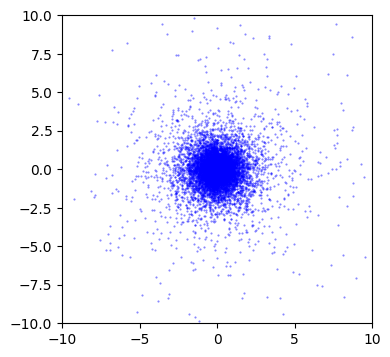

In [25]:
import numpy as np
from prngs.mersenne_twister import MersenneTwister

# GIVEN IMPLEMENTATION (sheet 7)
# This code generates a random distribution of stars in 3D space, with a specified mass distribution.

# initialise the random number generator
rng = np.random.Generator(np.random.PCG64(seed=12345))
rng = LCG(m=2**32, a=1664525, c=1013904223, seed=42)

# Sample isotropic 3d vectors with a given modulus
def rand_vec3d( mod ):
    N = len(mod)
    phi = 2*np.pi*np.array([rng.next() for _ in range(N)])
    theta = np.arccos( 2*np.array([rng.next() for _ in range(N)])-1 )
    v3d = np.zeros( (N,3) )
    v3d[:,0] = mod * np.cos( phi ) * np.sin( theta )
    v3d[:,1] = mod * np.sin( phi ) * np.sin( theta )
    v3d[:,2] = mod * np.cos( theta )
    # subtract mean
    for i in range(3):
        v3d[:,i] -= np.mean(v3d[:,i])
    return v3d

# number of stars
N = 10000

# particle mass is 1/N
m = 1/N

# Sampling the mass, draw radii through inversion sampling from the cumulative mass M
# Use the existing LCG instance 'rng' to sample the mass
U = np.array([rng.next() for _ in range(N)])
rsamp = U**(1/3)/np.sqrt((1-U**(2/3)))

# create N empty 3D vectors
x3d = rand_vec3d( rsamp )

# make a scatter plot of the stars
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(x3d[:,0], x3d[:,1], marker='.', s=1, c='b', alpha=0.5)
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)

rng = MersenneTwister(seed=42)

U = np.array([rng.next() for _ in range(N)])
rsamp = U**(1/3)/np.sqrt((1-U**(2/3)))

# create N empty 3D vectors
x3d = rand_vec3d( rsamp )

# make a scatter plot of the stars
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(x3d[:,0], x3d[:,1], marker='.', s=1, c='b', alpha=0.5)
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)

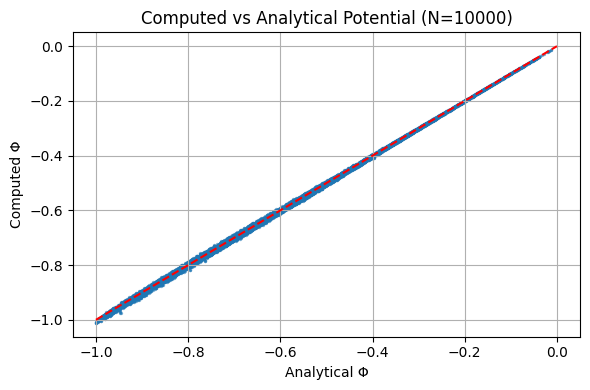

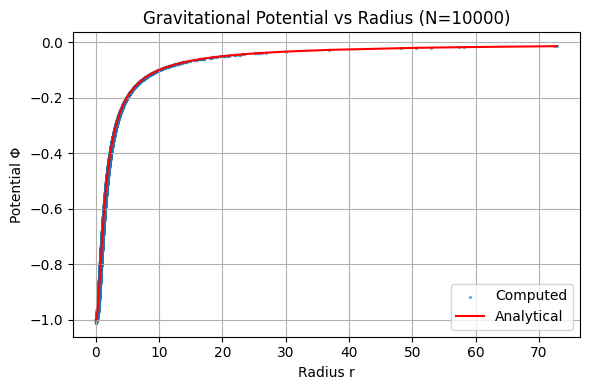

In [ ]:
# analytical tests to check for Plummer stuff from Sheet 7

import matplotlib.pyplot as plt

def compute_potential(x3d, m):
    N = x3d.shape[0]
    phi = np.zeros(N)
    for i in range(N):
        # compute all distances to point i (excluding i itself)
        r_ij = np.linalg.norm(x3d[i] - x3d, axis=1)
        r_ij[i] = np.inf  # avoid division by zero
        phi[i] = -np.sum(m / r_ij)
    return phi

radii = np.linalg.norm(x3d, axis=1)
phi_analytic = -1 / np.sqrt(1 + radii**2)

phi_computed = compute_potential(x3d, m)

# Plot computed vs analytic
plt.figure(figsize=(6, 4))
plt.scatter(phi_analytic, phi_computed, s=2, alpha=0.5)
plt.xlabel("Analytical Φ")
plt.ylabel("Computed Φ")
plt.title("Computed vs Analytical Potential (N=x)")
plt.grid(True)
plt.plot([-1, 0], [-1, 0], 'r--')  # y = x line
plt.tight_layout()

# Plot potential vs radius
plt.figure(figsize=(6, 4))
plt.scatter(radii, phi_computed, s=2, alpha=0.5, label='Computed')
plt.plot(np.sort(radii), -1/np.sqrt(1 + np.sort(radii)**2), 'r-', label='Analytical')
plt.xlabel("Radius r")
plt.ylabel("Potential Φ")
plt.title("Gravitational Potential vs Radius (N=x)")
plt.legend()
plt.grid(True)
plt.tight_layout()

In [ ]:
# maybe also acceleration computation